In [1]:
import math
import random
import operator
import numpy as np
import pandas as pd
from pprint import pprint
from copy import deepcopy
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Dataset/AdmissionDataset/data.csv")
training = df.sample(frac=0.8, random_state=200)
validation = df.drop(training.index)

In [3]:
# Remove predict label column and store it somewhere else
tlabel = training['Chance of Admit ']
training = training.drop('Chance of Admit ',axis = 1)

vlabel = validation['Chance of Admit ']
validation = validation.drop('Chance of Admit ',axis = 1)

In [4]:
# Remove 'Serial No.' Column
training = training.drop('Serial No.',axis = 1)

validation = validation.drop('Serial No.',axis = 1)

In [5]:
# Normalize training and validation data
training = (training - training.mean())/training.std()

validation = (validation - validation.mean())/validation.std()

In [6]:
# Set threshold to 0.5 and value above 0.5 to 1, value below 0.5 to 0
tlabel[tlabel >= 0.5] = 1
tlabel[tlabel < 0.5] = 0
vlabel[vlabel >= 0.5] = 1
vlabel[vlabel < 0.5] = 0

In [7]:
# Convert to NumPy Array
tlabel = [tlabel]
tlabel = np.array(tlabel)
tlabel = tlabel.T

In [8]:
# Appending 1 to training and valiadation data
training.insert(0, 'Ones', np.zeros(len(training))+1, allow_duplicates=False)

validation.insert(0, 'Ones', np.zeros(len(validation))+1, allow_duplicates=False)

In [9]:
training = training.values

beta = np.zeros((training.shape[1],1))

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def gradient(beta, x, y):
    X_beta = np.dot(x, beta)
    return np.dot(x.T, sigmoid(X_beta) - y)

def gradient_descent(beta, x, learing_rate, threshold, iter_count,y):
    m = y.shape[0]
    
    for i in range(iter_count):
        old_beta = deepcopy(beta)
        
        temp = gradient(beta, x, y)
        
        beta = beta - (learing_rate * temp / m)
            
    return beta


beta = gradient_descent(beta, training, 0.01, 0.0001, 500, tlabel)

predicted = sigmoid(np.array(np.dot(validation, beta)))

predicted[predicted >= 0.5] = 1
predicted[predicted < 0.5] = 0

vlabel = np.array(vlabel).T
accuracy = len([1 for x in range(len(vlabel)) if vlabel[x] == predicted[x]])/float(len(vlabel))
print 'Accuracy : ', accuracy

Accuracy :  0.977777777778


# Part 2

In [10]:
def euclidean(x, y, length):
    distance = 0
    for i in range(length):
        distance = distance + np.square(x[i] - y[i])
    return np.sqrt(distance)

In [11]:
df = pd.read_csv("Dataset/AdmissionDataset/data.csv")
df.loc[df['Chance of Admit '] >= 0.5, 'Chance of Admit '] = 1
df.loc[df['Chance of Admit '] < 0.5, 'Chance of Admit '] = 0

training = df.sample(frac=0.8, random_state=200)
validation = df.drop(training.index)

training = training.drop('Serial No.',axis = 1)
validation = validation.drop('Serial No.',axis = 1)

validation_without_class = validation.iloc[:,0:7]

In [12]:
def knn(tdata, vdata, k):
    distances = []
    length = len(vdata)-1
    
    for index, rows in tdata.iterrows():
        distances.append((rows['Chance of Admit '], euclidean(rows, vdata, length)))
    
    distances.sort(key=operator.itemgetter(1))
    
    neighbor = []
    for i in range(k):
        neighbor.append(distances[i][0])
    
    Votes = {}
    for x in range(len(neighbor)):
        response = neighbor[x]
        if response in Votes:
            Votes[response] += 1
        else:
            Votes[response] = 1
    
    sortedVotes = sorted(Votes.items(),key = operator.itemgetter(1),reverse=True)
    
    return sortedVotes[0][0]

In [13]:
def knn_stats():
    actual = validation['Chance of Admit '].tolist()

    predicted = []

    for index, rows in validation_without_class.iterrows():
        predicted.append(knn(training, rows, 11))

    count = 0

    for i in range(len(predicted)):
        if predicted[i] == actual[i]:
            count = count + 1

    accuracy = float(count)/len(actual)

    print 'Accuracy: ', accuracy

In [14]:
knn_stats()

Accuracy:  0.966666666667


# Part 3

In [15]:
def pre_process(threshold):
    training = df.sample(frac=0.8,random_state=200)
    validation = df.drop(training.index)
    
    tlabel = training['Chance of Admit ']
    training = training.drop('Chance of Admit ', axis=1)
    
    vlabel = validation['Chance of Admit ']
    validation = validation.drop('Chance of Admit ', axis=1)

    training = training.drop('Serial No.', axis=1)
    validation = validation.drop('Serial No.', axis=1)

    training = (training - training.mean())/training.std()
    validation = (validation - validation.mean())/validation.std()

    tlabel[tlabel >= threshold] = 1
    tlabel[tlabel < threshold] = 0
    vlabel[vlabel >= threshold] = 1
    vlabel[vlabel < threshold] = 0
    
    tlabel = [tlabel]
    tlabel = np.array(tlabel)
    vlabel = [vlabel]
    vlabel = np.array(vlabel)
    tlabel = tlabel.T
    
    
    training.insert(0, 'Ones', np.zeros(len(training))+1, allow_duplicates=False)

    validation.insert(0, 'Ones', np.zeros(len(validation))+1, allow_duplicates=False)
    
    training = training.values
    
    return training, validation, tlabel, vlabel

threshold = []
recall = []
precision = []
accuracy = []

for i in range(3,8):
    i = i*0.1
    train, test, tlabel, vlabel = pre_process(i)
    
    beta = np.zeros((training.shape[1],1))
    beta = gradient_descent(beta, train, 0.01, 0.0001, 500, tlabel)
    
    test_array = np.dot(test, beta)
    test_array = np.array(test_array)
    
    predicted = sigmoid(test_array)
    
    for k in range(len(predicted)):
        if predicted[k] >= i:
            predicted[k] = 1
        else:
            predicted[k] = 0

    vlabel = np.array(vlabel).T
    
    accuracy.append(metrics.accuracy_score(vlabel, predicted))
    
    precision.append(metrics.precision_score(vlabel, predicted))
    
    threshold.append(i)
    
    recall.append(metrics.recall_score(vlabel, predicted))

print(threshold)
print(precision)
print(recall)

[0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001]
[0.9555555555555556, 0.9555555555555556, 0.9772727272727273, 0.9879518072289156, 1.0]
[1.0, 1.0, 1.0, 0.9534883720930233, 0.7906976744186046]


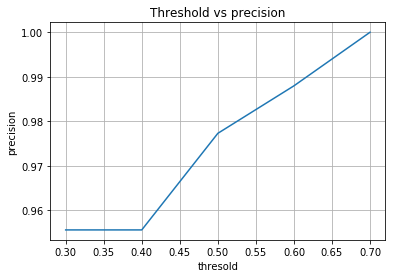

In [16]:
plt.plot(threshold, precision)

plt.xlabel('thresold')
plt.ylabel('precision')
plt.title('Threshold vs precision')
plt.grid(True)

plt.show()

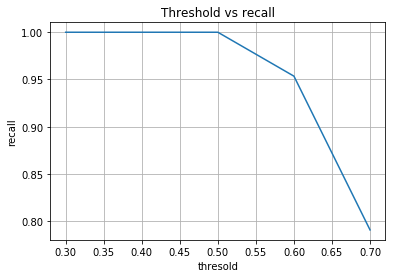

In [17]:
plt.plot(threshold, recall)

plt.xlabel('thresold')
plt.ylabel('recall')
plt.title('Threshold vs recall')
plt.grid(True)

plt.show()